In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import arviz as az
import pymc as pm

In [2]:
az.style.use("arviz-white")
plt.rcParams['figure.dpi'] = 300
pm.__version__

'5.3.1'

## API overview

In [3]:
RANDOM_SEED = 892
rng = np.random.default_rng(RANDOM_SEED)

In [4]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)

In [5]:
with pm.Model():
    obs = pm.Normal("x", mu=0, sigma=1, observed=[-1, 0, 0, 1])

In [6]:
with pm.Model():
    mu = pm.Normal("mu", mu=0, sigma=1)
    sigma = pm.Exponential("sigma", 1)
    x = pm.Normal("x", mu=mu, sigma=sigma)

In [7]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)
    y = pm.Gamma("y", alpha=1, beta=1)
    plus_2 = x + 2
    summed = x + y
    squared = x**2
    sined = pm.math.sin(x)

In [8]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)
    plus_2 = pm.Deterministic("x plus 2", x + 2)

In [9]:
with pm.Model():
    # not recommended:
    x = [pm.Normal(f"x_{i}", mu=0, sigma=1) for i in range(3)]

In [10]:
with pm.Model() as model:
    x = pm.Normal("x", mu=0, sigma=1, shape=3)  # length-3 array

In [11]:
coords = {"city": ["Santiago", "Mumbai", "Tokyo"]}
with pm.Model(coords=coords) as model:
    # recommended:
    x = pm.Normal("x", mu=0, sigma=1, dims="city")

In [12]:
with model:
    y = x[0] * x[1]  # indexing is supported
    x.dot(x.T)  # linear algebra is supported
    # x.sel(city="Mumbai")  # not yet supported

In [13]:
with pm.Model() as model:
    x = pm.Normal("x", mu=0, sigma=1)
model.initial_point()

{'x': array(0.)}

In [14]:
with pm.Model() as model:
    x = pm.Normal("x", mu=0, sigma=1)
    y = pm.Normal("y", mu=0, sigma=1, initval=-3)

# To get initial values for all RVs:
model.initial_point()

{'x': array(0.), 'y': array(-3.)}

In [15]:
rng = np.random.default_rng(seed=0)
x = np.linspace(-1, 1)
y = rng.normal(x*3, 1)
with pm.Model() as model:
    a = pm.Normal("a", mu=0, sigma=1)
    b = pm.HalfNormal("b", sigma=1)
    mu = pm.Deterministic("mu", a + b*x)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=y)

In [16]:
model.basic_RVs

[a ~ Normal(0, 1), b ~ HalfNormal(0, 1), obs ~ Normal(mu, 1)]

In [17]:
model.free_RVs

[a ~ Normal(0, 1), b ~ HalfNormal(0, 1)]

In [18]:
model.observed_RVs

[obs ~ Normal(mu, 1)]

In [19]:
model.compile_logp()({"a": 0.5, "b_log__":1.2})

array(-73.39055683)

In [20]:
with model:
    fit = pm.find_MAP()

fit['a'], fit['b']

(array(0.12646729), array(3.38501407))

In [21]:
with model:
    idata = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


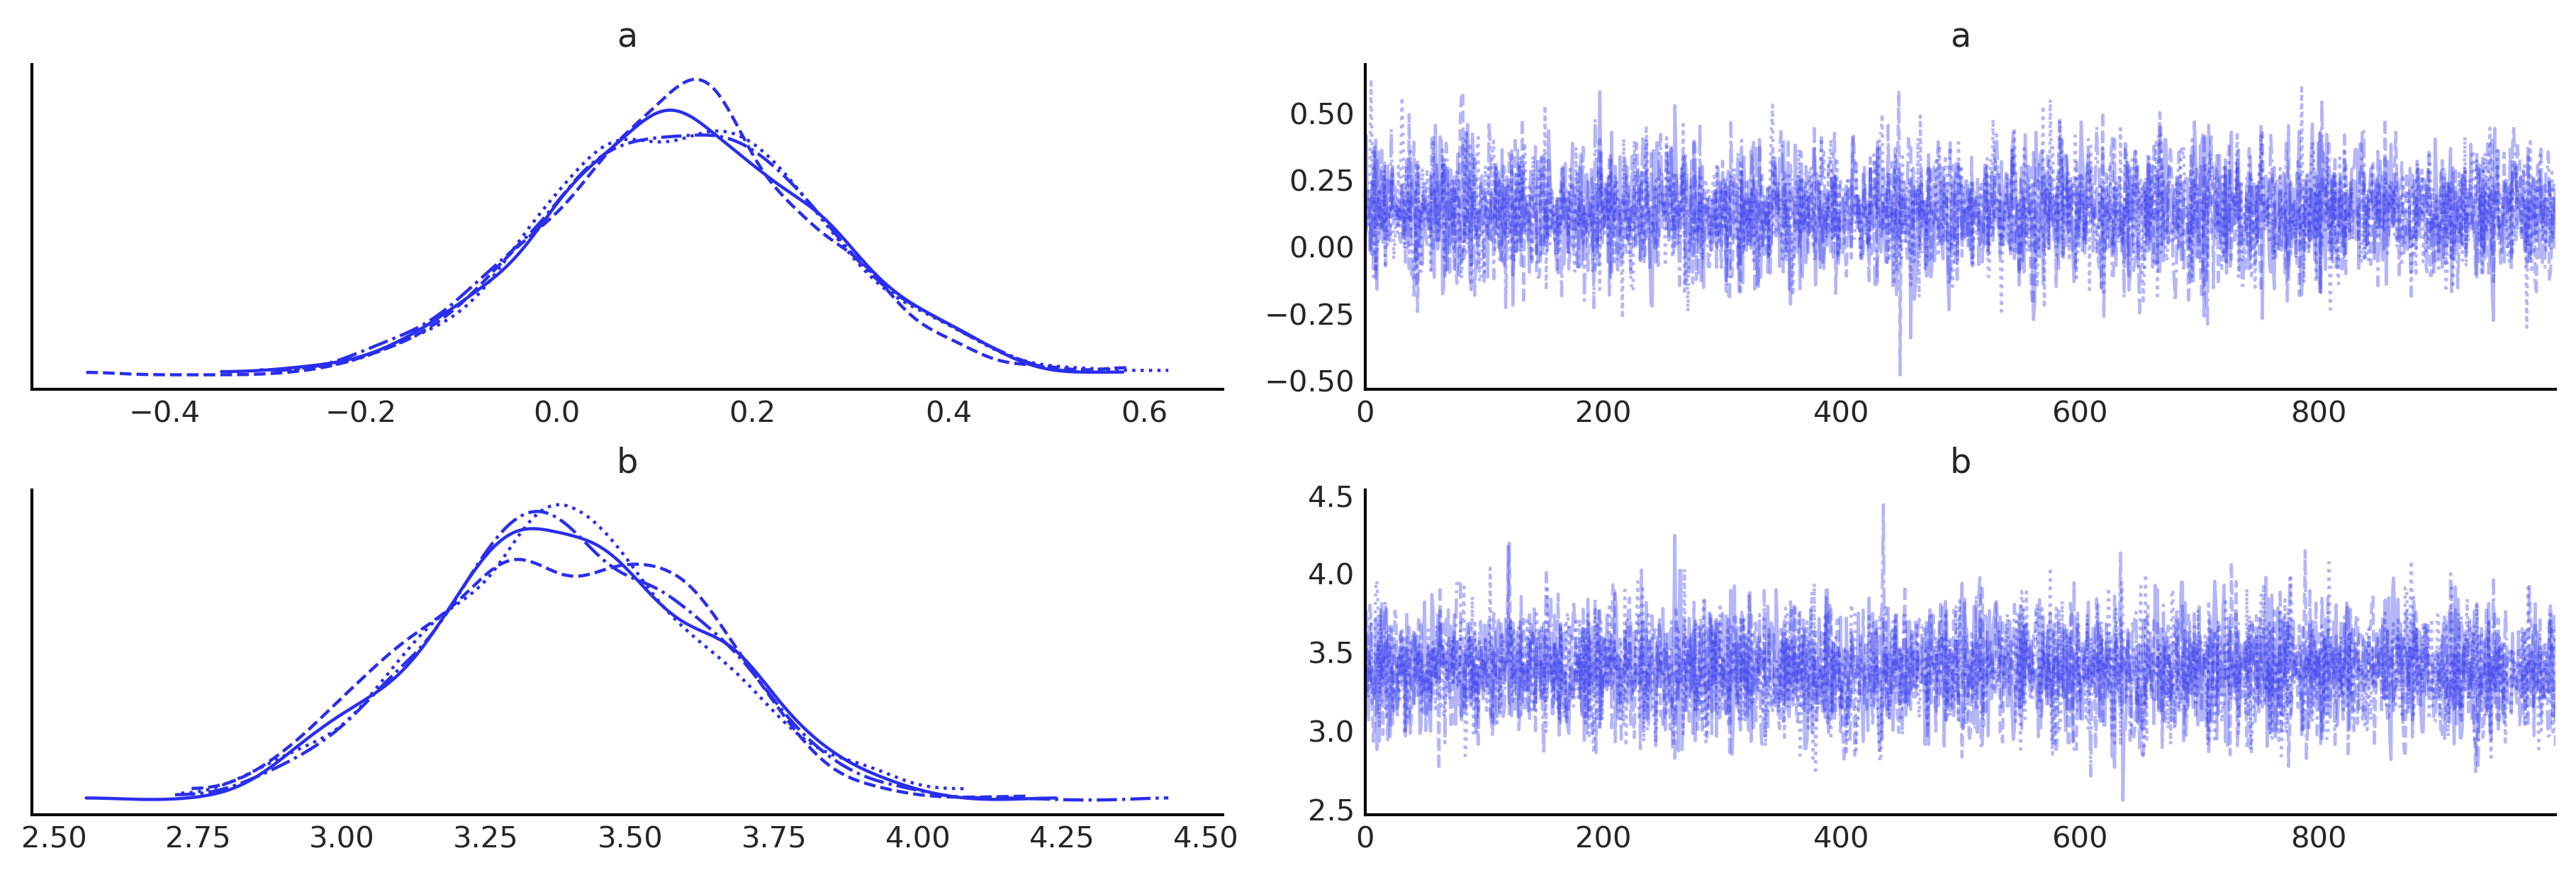

In [22]:
az.plot_trace(idata, var_names=['a', 'b'])
plt.savefig("sample_trace.png")

In [23]:
az.summary(idata, var_names=['a', 'b'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail   
a  0.129  0.139  -0.118    0.404      0.002    0.002    3816.0    3118.0  \
b  3.385  0.237   2.938    3.815      0.004    0.003    4211.0    2654.0   

   r_hat  
a    1.0  
b    1.0

## Case studies
### Coal mining disasters

In [24]:
# fmt: off
disaster_data = pd.Series([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                           3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                           2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3,
                           0, 0, 1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1,
                           1, 1, 0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1,
                           0, 2, 3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2,
                           0, 0, 1, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
                           1, 0, 1])

years = np.arange(1851, 1962)

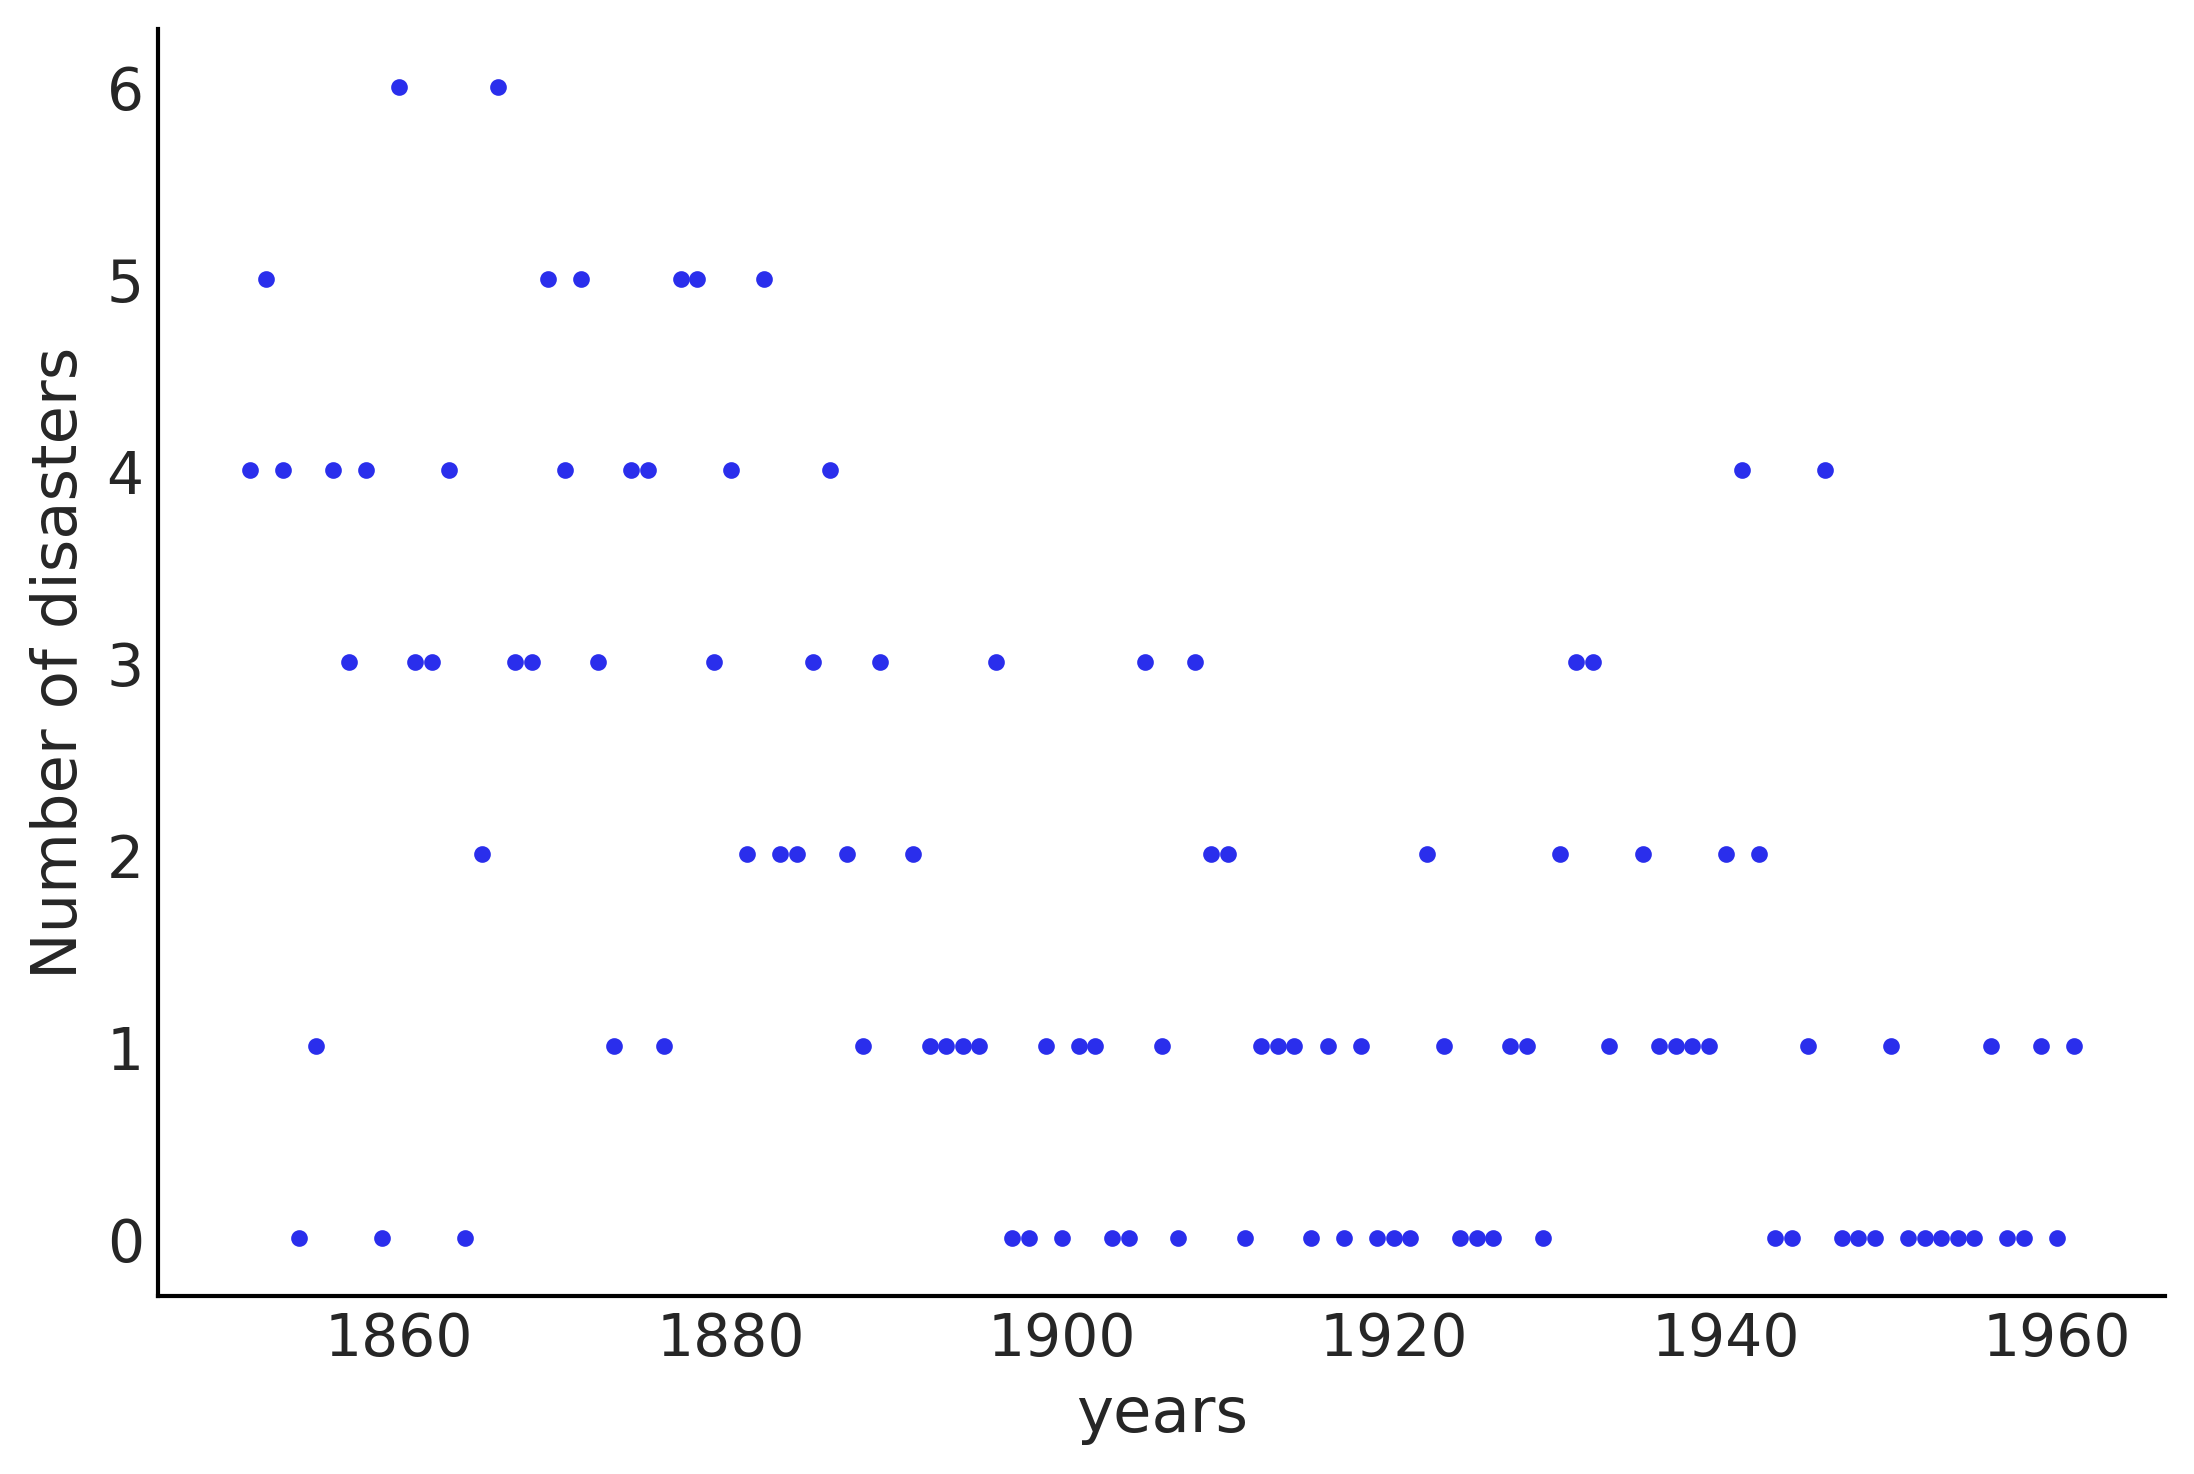

In [25]:
plt.plot(years, disaster_data, '.')
plt.ylabel("Number of disasters")
plt.xlabel("years");

In [26]:
with pm.Model() as mining:
    # Prior for the switch-point 
    sp = pm.DiscreteUniform('sp', lower=years.min(), upper=years.max())

    # Priors for the rate before (t_0) and after (t_1)
    t_0 = pm.Exponential('t_0', 1)
    t_1 = pm.Exponential('t_1', 1)

    # We assign the rate according to the sp,
    rate = pm.Deterministic("rate", pm.math.switch(sp >= years, t_0, t_1))

    # Likelihood
    acc = pm.Poisson('acc', rate, observed=disaster_data)
    
    # We compute the posterior
    idata = pm.sample(tune=2000, idata_kwargs={"log_likelihood":True}, random_seed=1791)
    idata.extend(pm.sample_prior_predictive(random_seed=1791))
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=1791))

/home/osvaldo/anaconda3/envs/pymc/lib/python3.10/site-packages/pymc/model.py:1407: ImputationWarning: Data in acc contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [sp]
>>Metropolis: [acc_missing]
>NUTS: [t_0, t_1]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 4 seconds.
Sampling: [acc_missing, acc_observed, sp, t_0, t_1]
Sampling: [acc_observed]


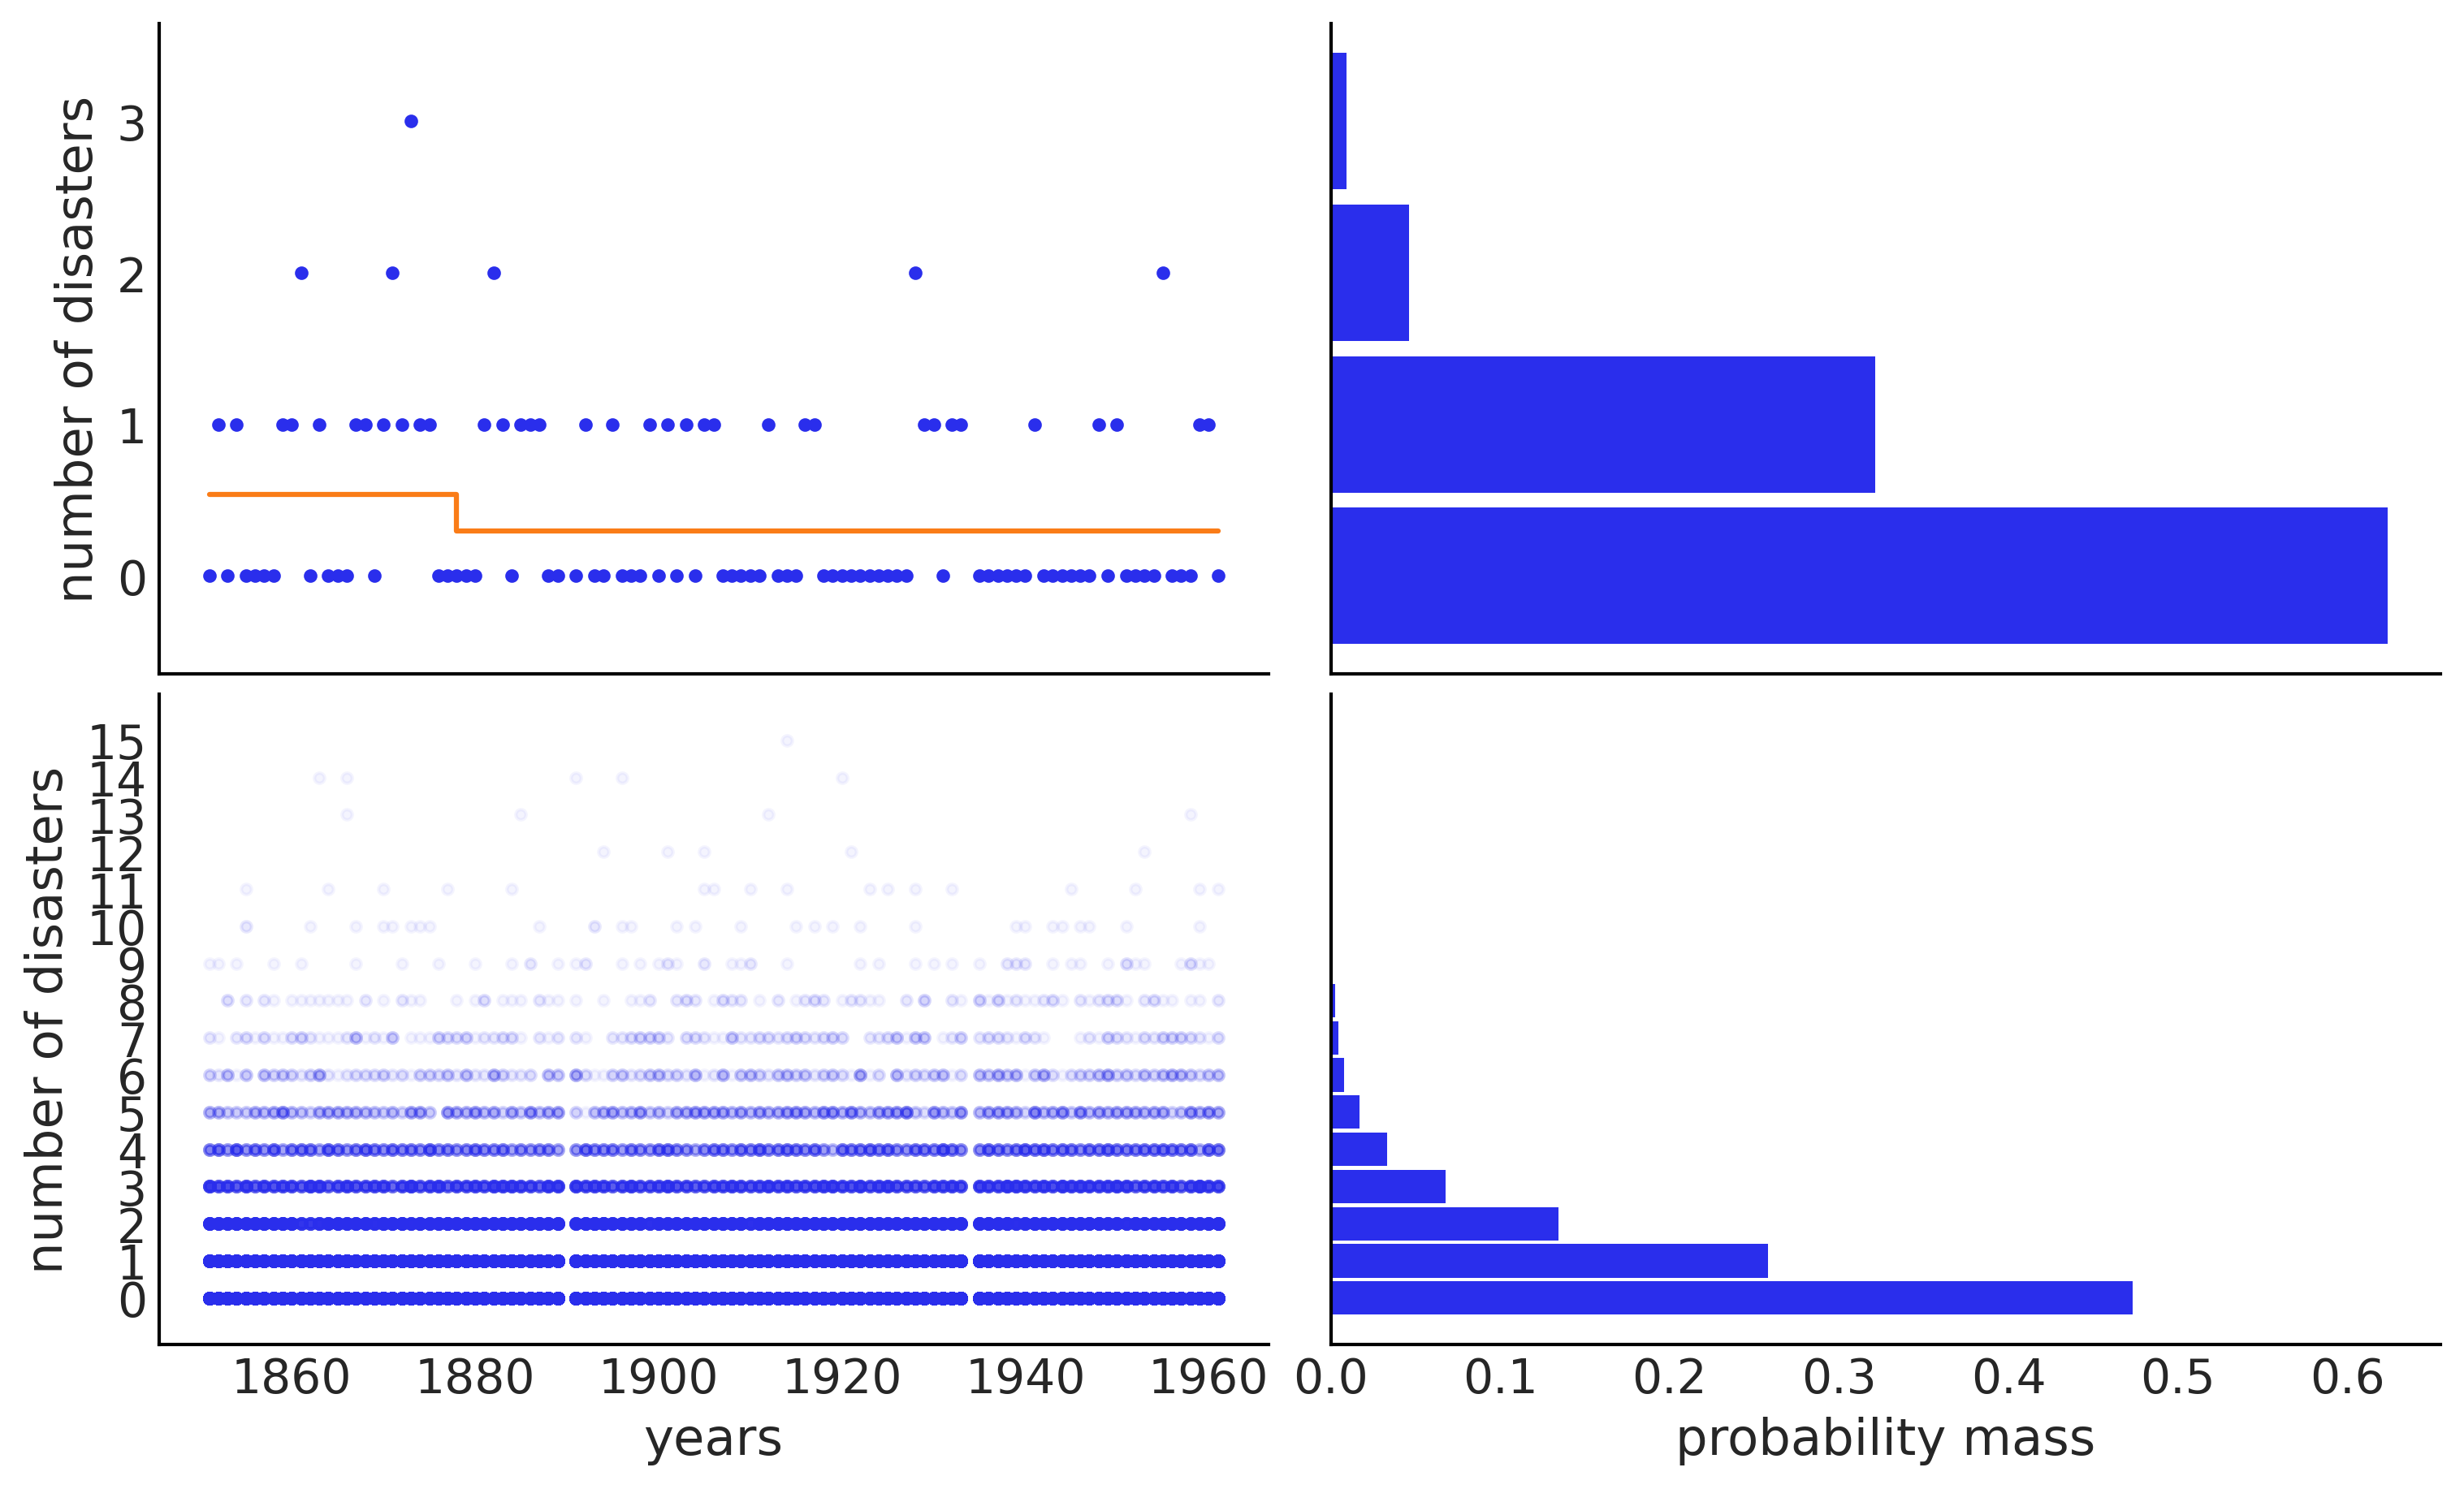

In [27]:
_, ax = plt.subplots(2,2, figsize=(10, 6), sharey="row", sharex="col")

ax[0,0].plot(years[np.isfinite(disaster_data)],
        idata.prior_predictive["acc_observed"].sel(draw=50).squeeze("chain").T, ".");
a_sample = idata.prior.sel(draw=50)
coco = np.full_like(years,  a_sample["t_1"].item(), dtype=float)
coco[a_sample["sp"]>=years] = a_sample["t_0"].item()
ax[0,0].step(years, coco)
ax[0,0].set_ylabel("number of disasters")

az.plot_dist(idata.prior_predictive["acc_observed"].sel(draw=50), ax=ax[0,1], rotated=True);


ax[1,0].plot(years[np.isfinite(disaster_data)],
        idata.prior_predictive["acc_observed"].squeeze("chain").T, "C0.", alpha=0.05);
ax[1,0].set_ylabel("number of disasters")
ax[1,0].set_xlabel("years")

az.plot_dist(idata.prior_predictive["acc_observed"], ax=ax[1,1], rotated=True);
ax[1,1].set_xlabel("probability mass")
plt.savefig("coal_mining_prior_predictive_check.png")

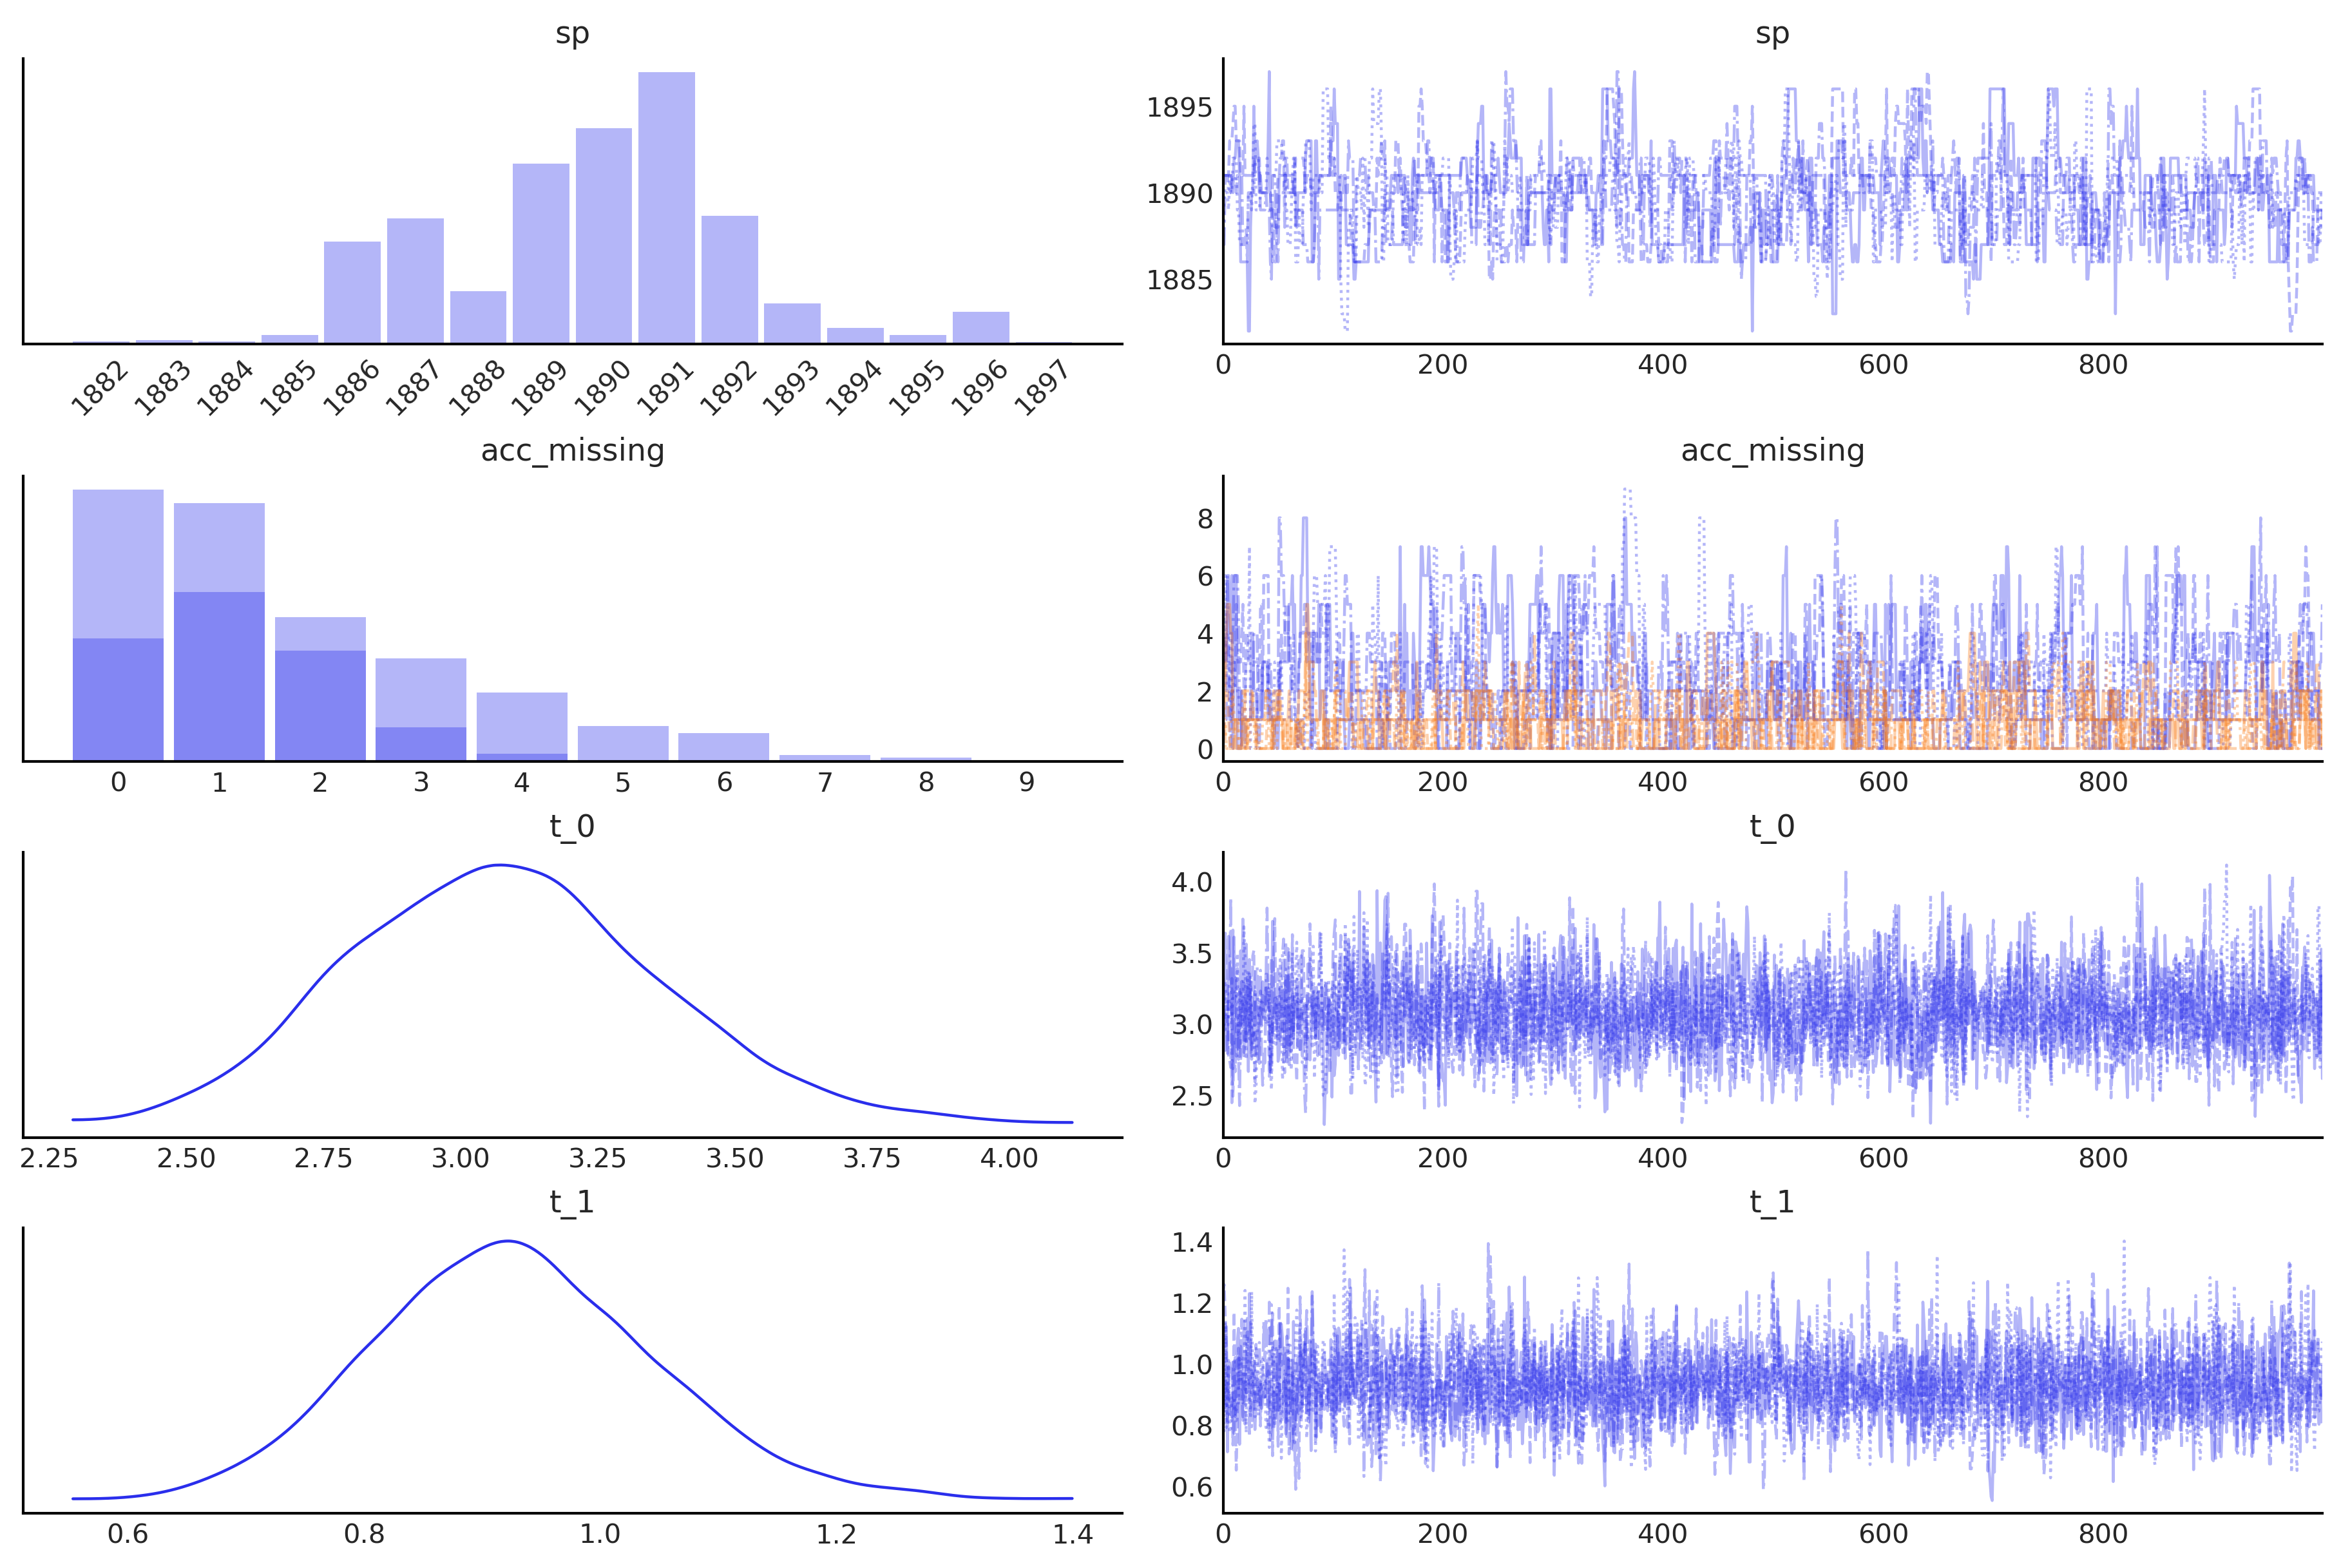

In [28]:
ax = az.plot_trace(idata, var_names=["~rate", "~acc"], combined=True);
[ticks.set_rotation(45) for ticks in ax[0, 0].get_xticklabels()];
plt.savefig("coal_mining_trace.png")

In [29]:
az.summary(idata, var_names=["~rate", "~acc"])

mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd   
sp              1889.822  2.362  1885.000  1893.000      0.108    0.076  \
acc_missing[0]     2.159  1.770     0.000     5.000      0.086    0.061   
acc_missing[1]     0.905  0.938     0.000     3.000      0.034    0.024   
t_0                3.082  0.283     2.584     3.638      0.006    0.004   
t_1                0.928  0.120     0.701     1.149      0.002    0.002   

                ess_bulk  ess_tail  r_hat  
sp                 486.0     484.0   1.01  
acc_missing[0]     410.0     451.0   1.01  
acc_missing[1]     774.0     822.0   1.00  
t_0               2349.0    2666.0   1.00  
t_1               2800.0    2480.0   1.00

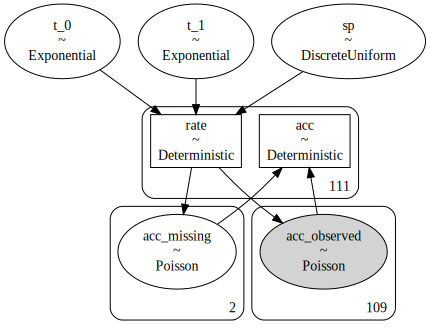

In [30]:
graphviz = pm.model_to_graphviz(mining)

graphviz_ = graphviz.copy()
graphviz_.graph_attr.update(dpi="300")
graphviz_.render(filename="mining_DAG", format="png", cleanup=True)
graphviz

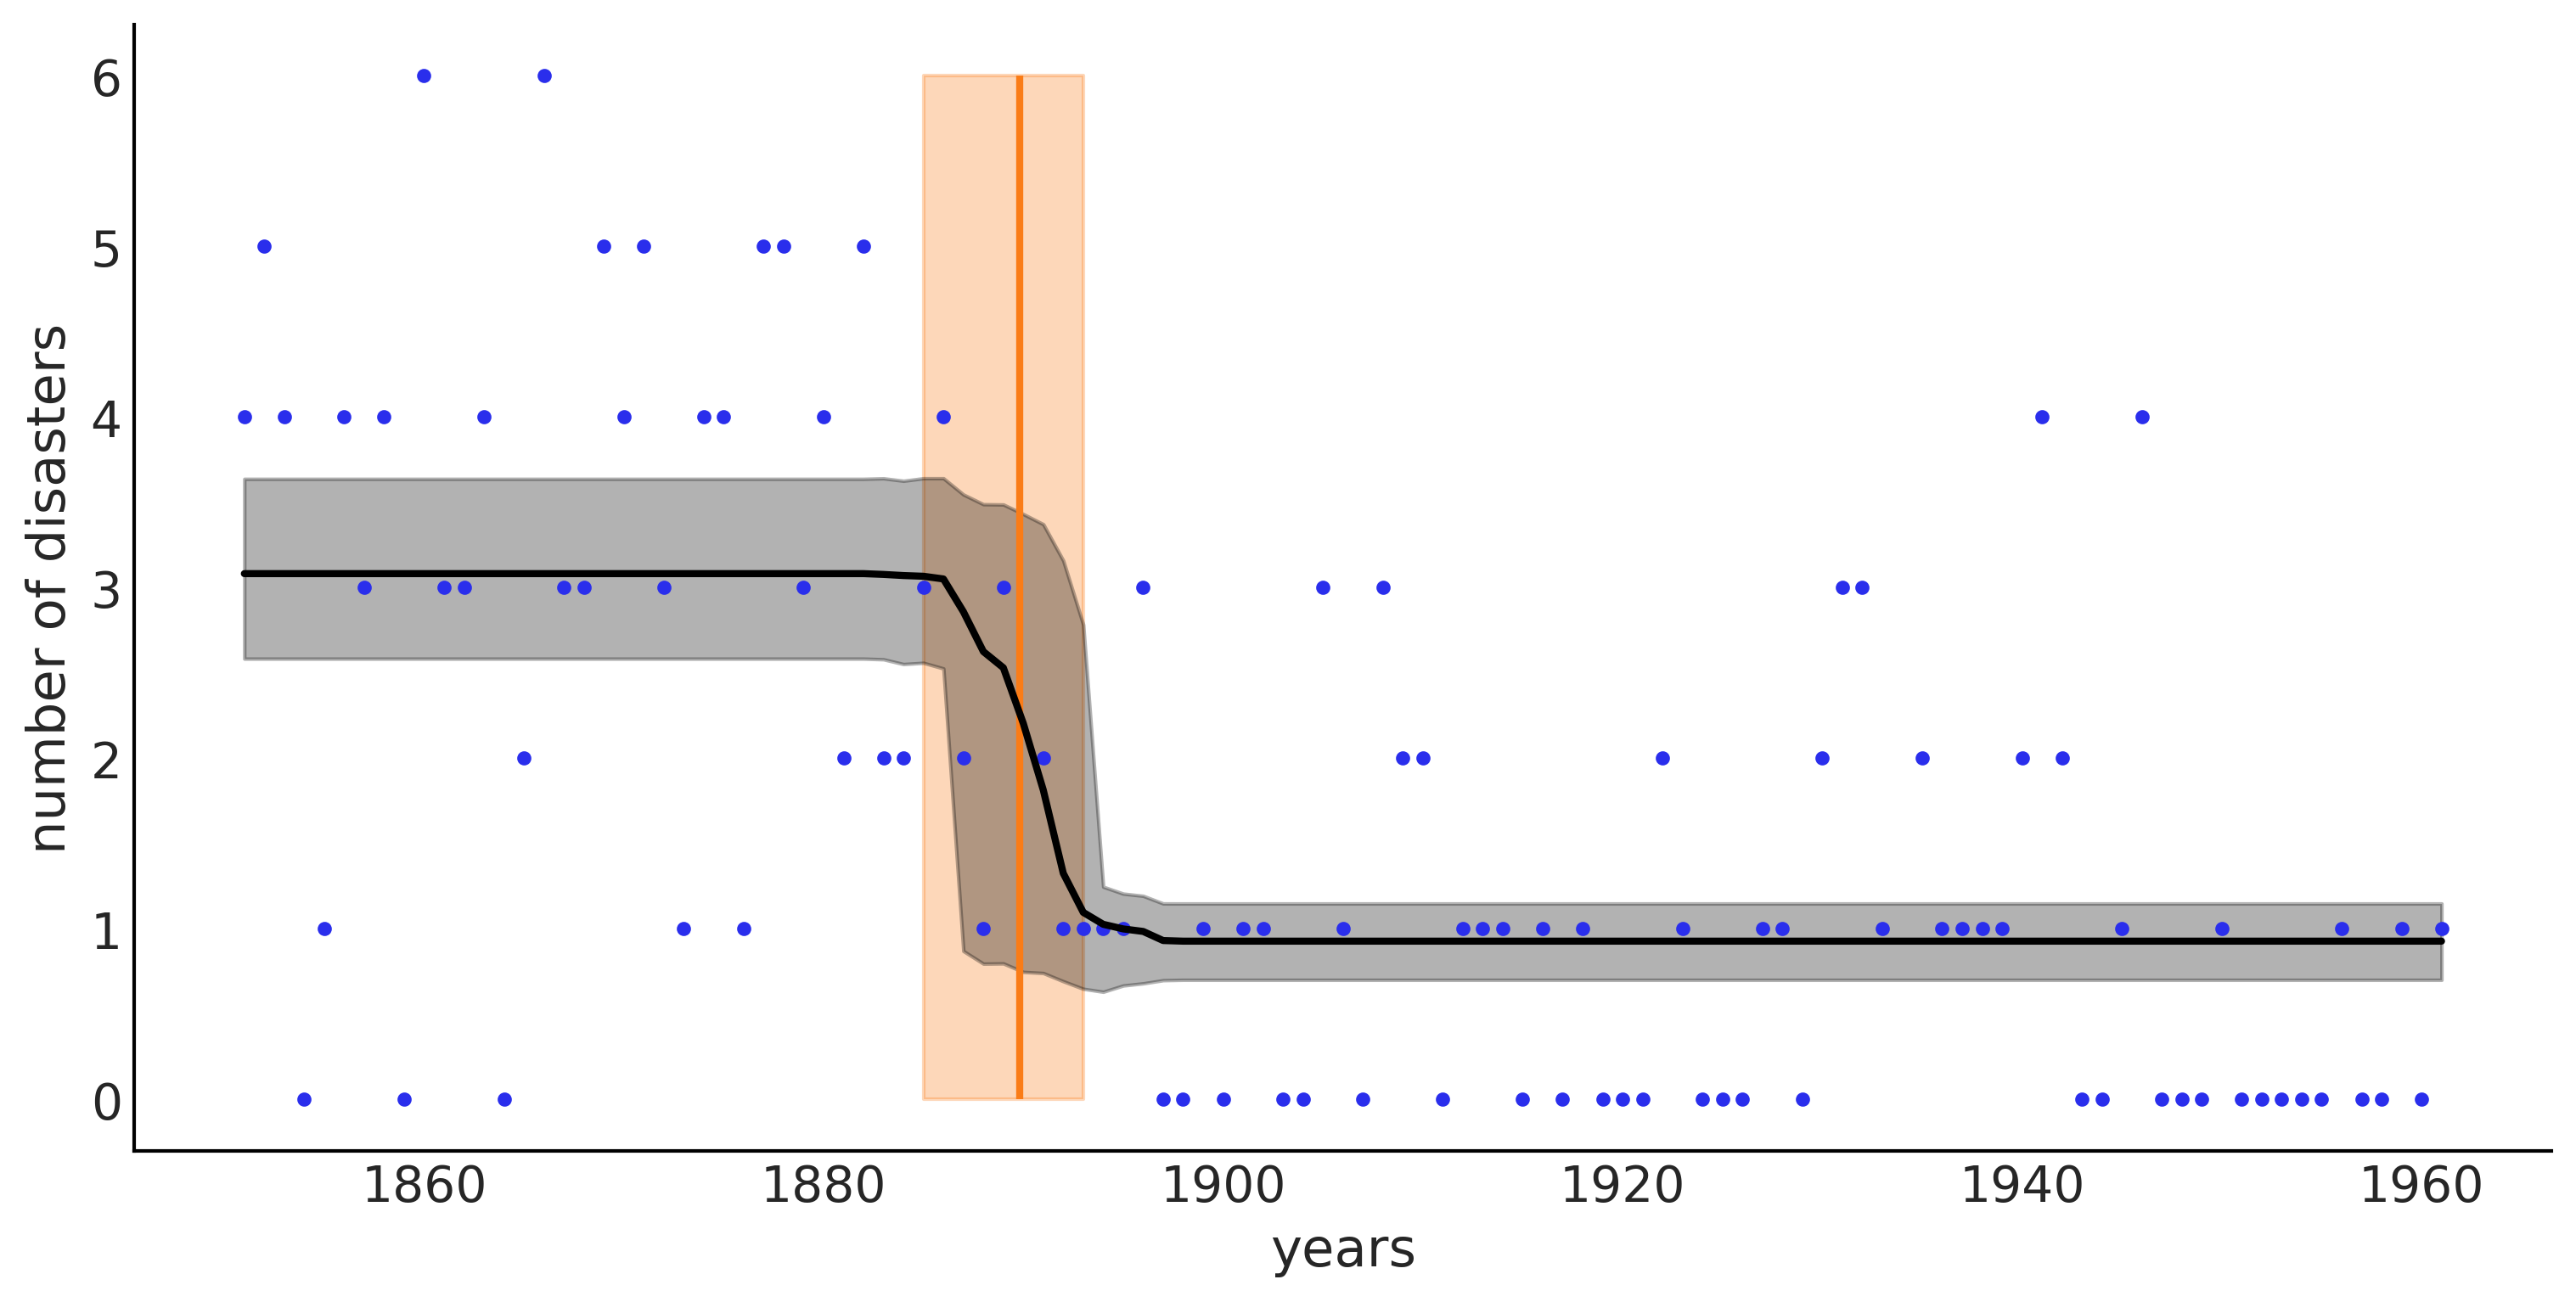

In [31]:
rate_mean = idata.posterior['rate'].mean(("chain", "draw"))
rate_hdi = az.hdi(idata.posterior["rate"].values)
sp_hdi = az.hdi(idata.posterior['sp'])["sp"]

_, ax = plt.subplots(1, figsize=(10, 5), sharey=True)
ax.plot(years, disaster_data, '.')

ax.set_ylabel("number of disasters")
ax.set_xlabel("years")

ax.vlines(idata.posterior['sp'].mean(("chain", "draw")), disaster_data.min(), disaster_data.max(), color='C1', lw=2)


ax.fill_betweenx([disaster_data.min(), disaster_data.max()], sp_hdi[0], sp_hdi[1], alpha=0.3, color='C1')
ax.plot(years, rate_mean,  'k', lw=2);
ax.fill_between(years, rate_hdi[:,0], rate_hdi[:,1], alpha=0.3, color='k');
plt.savefig("coal_mining_result.png")

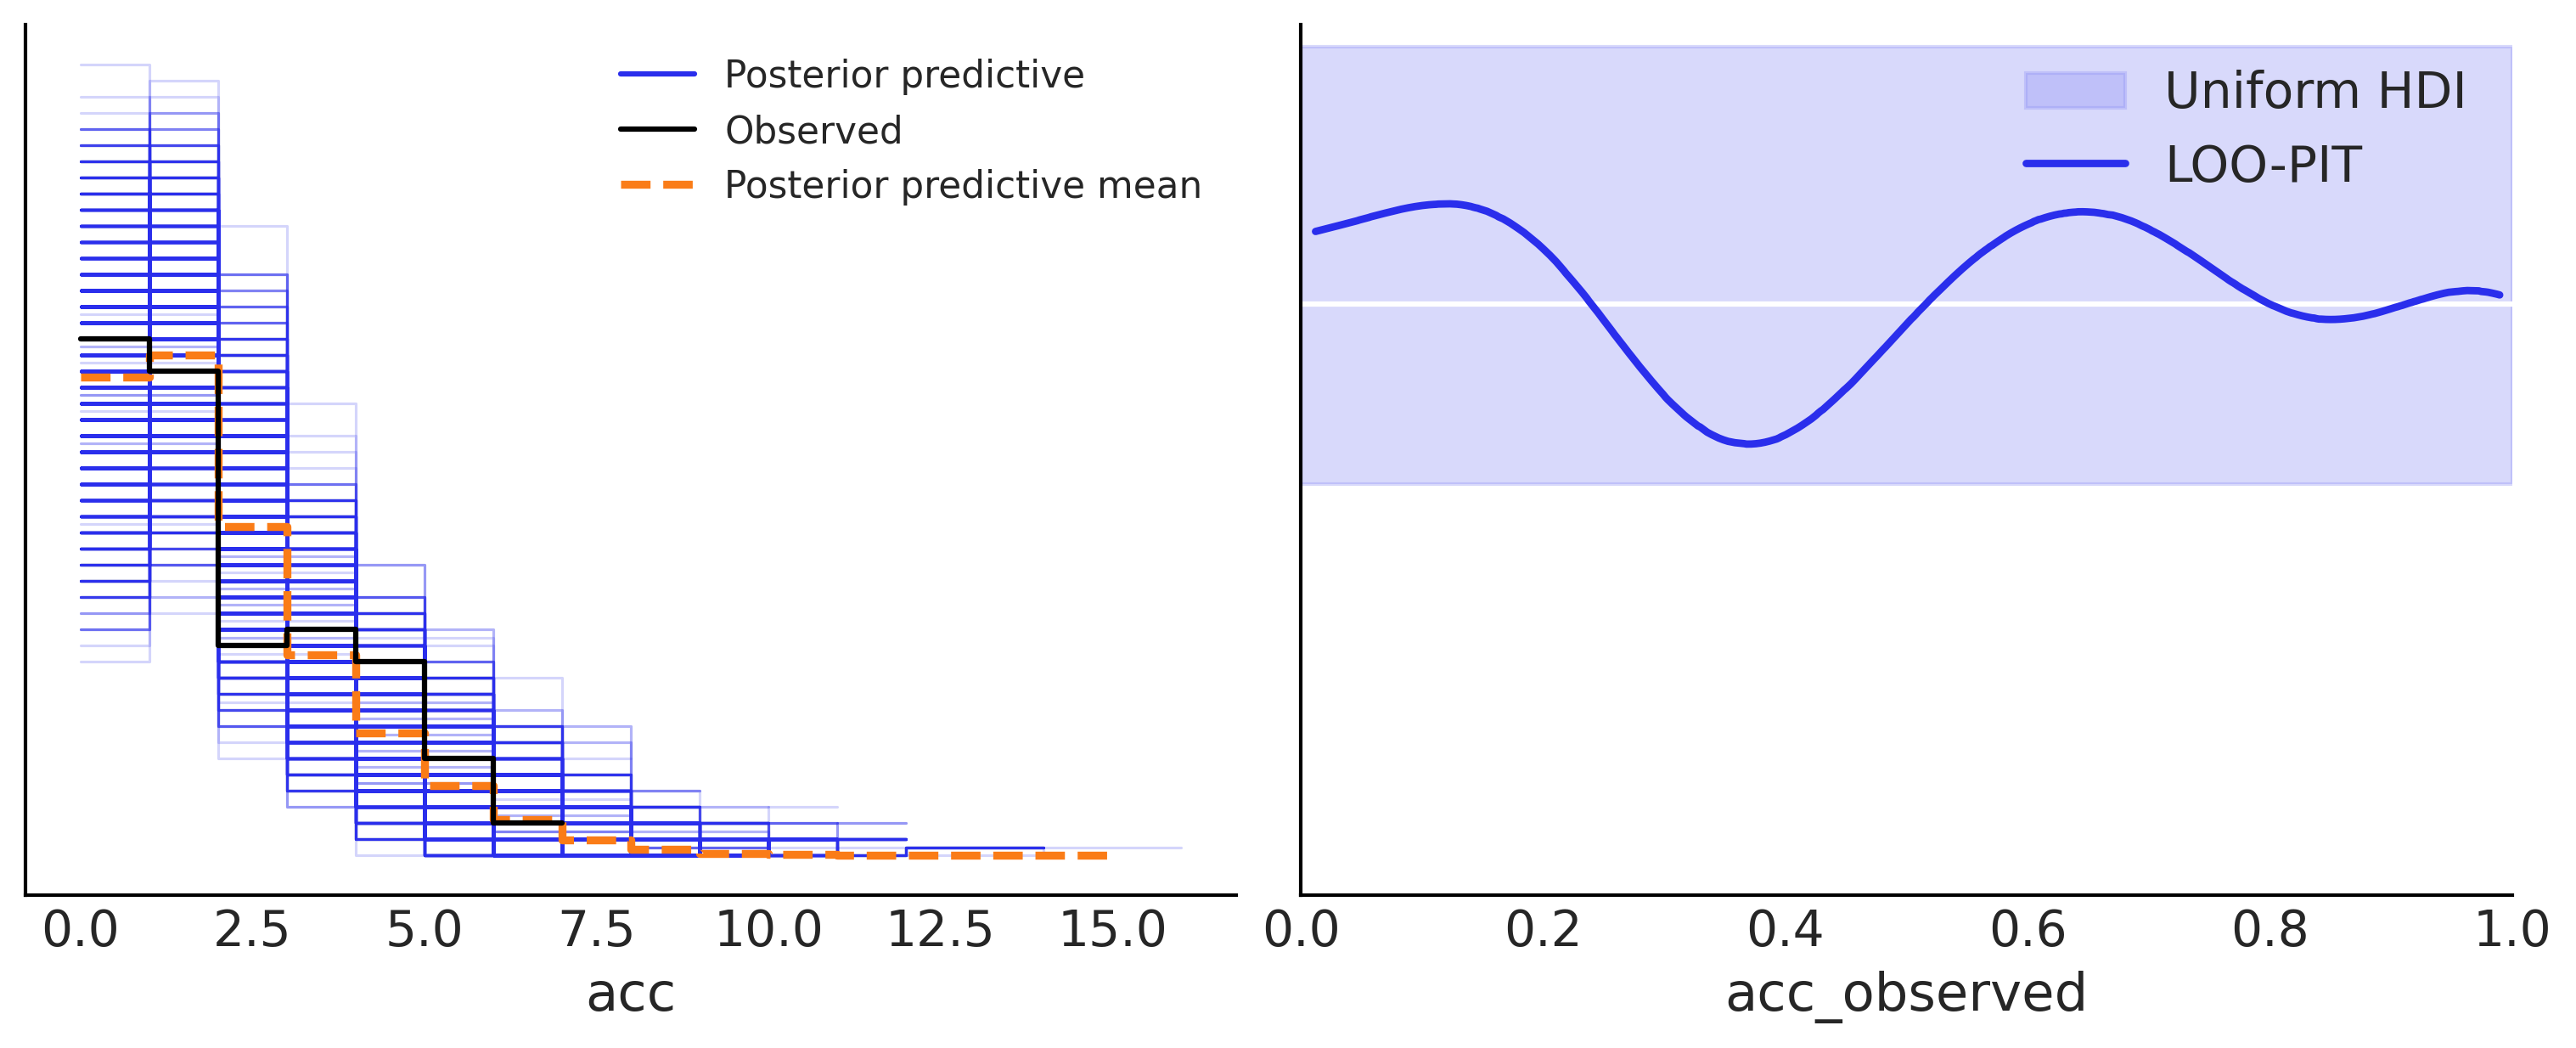

In [32]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))
az.plot_ppc(idata, ax=ax[0])
ax[0].set_xlabel("acc")
az.plot_loo_pit(idata, "acc_observed", ax=ax[1], use_hdi=True)
ax[1].set_yticks([])
plt.savefig("coal_mining_posterior_predictive_checks.png")

### Dirichlet mixture of multinomials

In [33]:
true_conc = 6.0
true_frac = np.array([0.45, 0.30, 0.15, 0.09, 0.01])
trees = ["pine", "oak", "ebony", "rosewood", "mahogany"]  # Tree species observed
# fmt: off
forests = [  # Forests observed
    "sunderbans", "amazon", "arashiyama", "trossachs", "valdivian",
    "bosc de poblet", "font groga", "monteverde", "primorye", "daintree",
]
# fmt: on
k = len(trees)
n = len(forests)
total_count = 50

true_p = stats.dirichlet(true_conc * true_frac).rvs(size=n)
observed_counts = np.vstack([stats.multinomial(n=total_count, p=p_i).rvs() for p_i in true_p])

In [34]:
# Marginalized Dirichlet-Multinomial Model
coords = {"tree": trees, "forest": forests}
with pm.Model(coords=coords) as model_dmm:
    frac = pm.Dirichlet("frac", a=np.ones(k), dims="tree")
    conc = pm.Lognormal("conc", mu=1, sigma=1)
    counts = pm.DirichletMultinomial(
        "counts", n=total_count, a=frac * conc, observed=observed_counts, dims=("forest", "tree")
    )
    idata_dmm = pm.sample(chains=4, return_inferencedata=True, random_seed=1791)
    idata_dmm.extend(pm.sample_posterior_predictive(idata_dmm, model=model_dmm, random_seed=1791))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [counts]


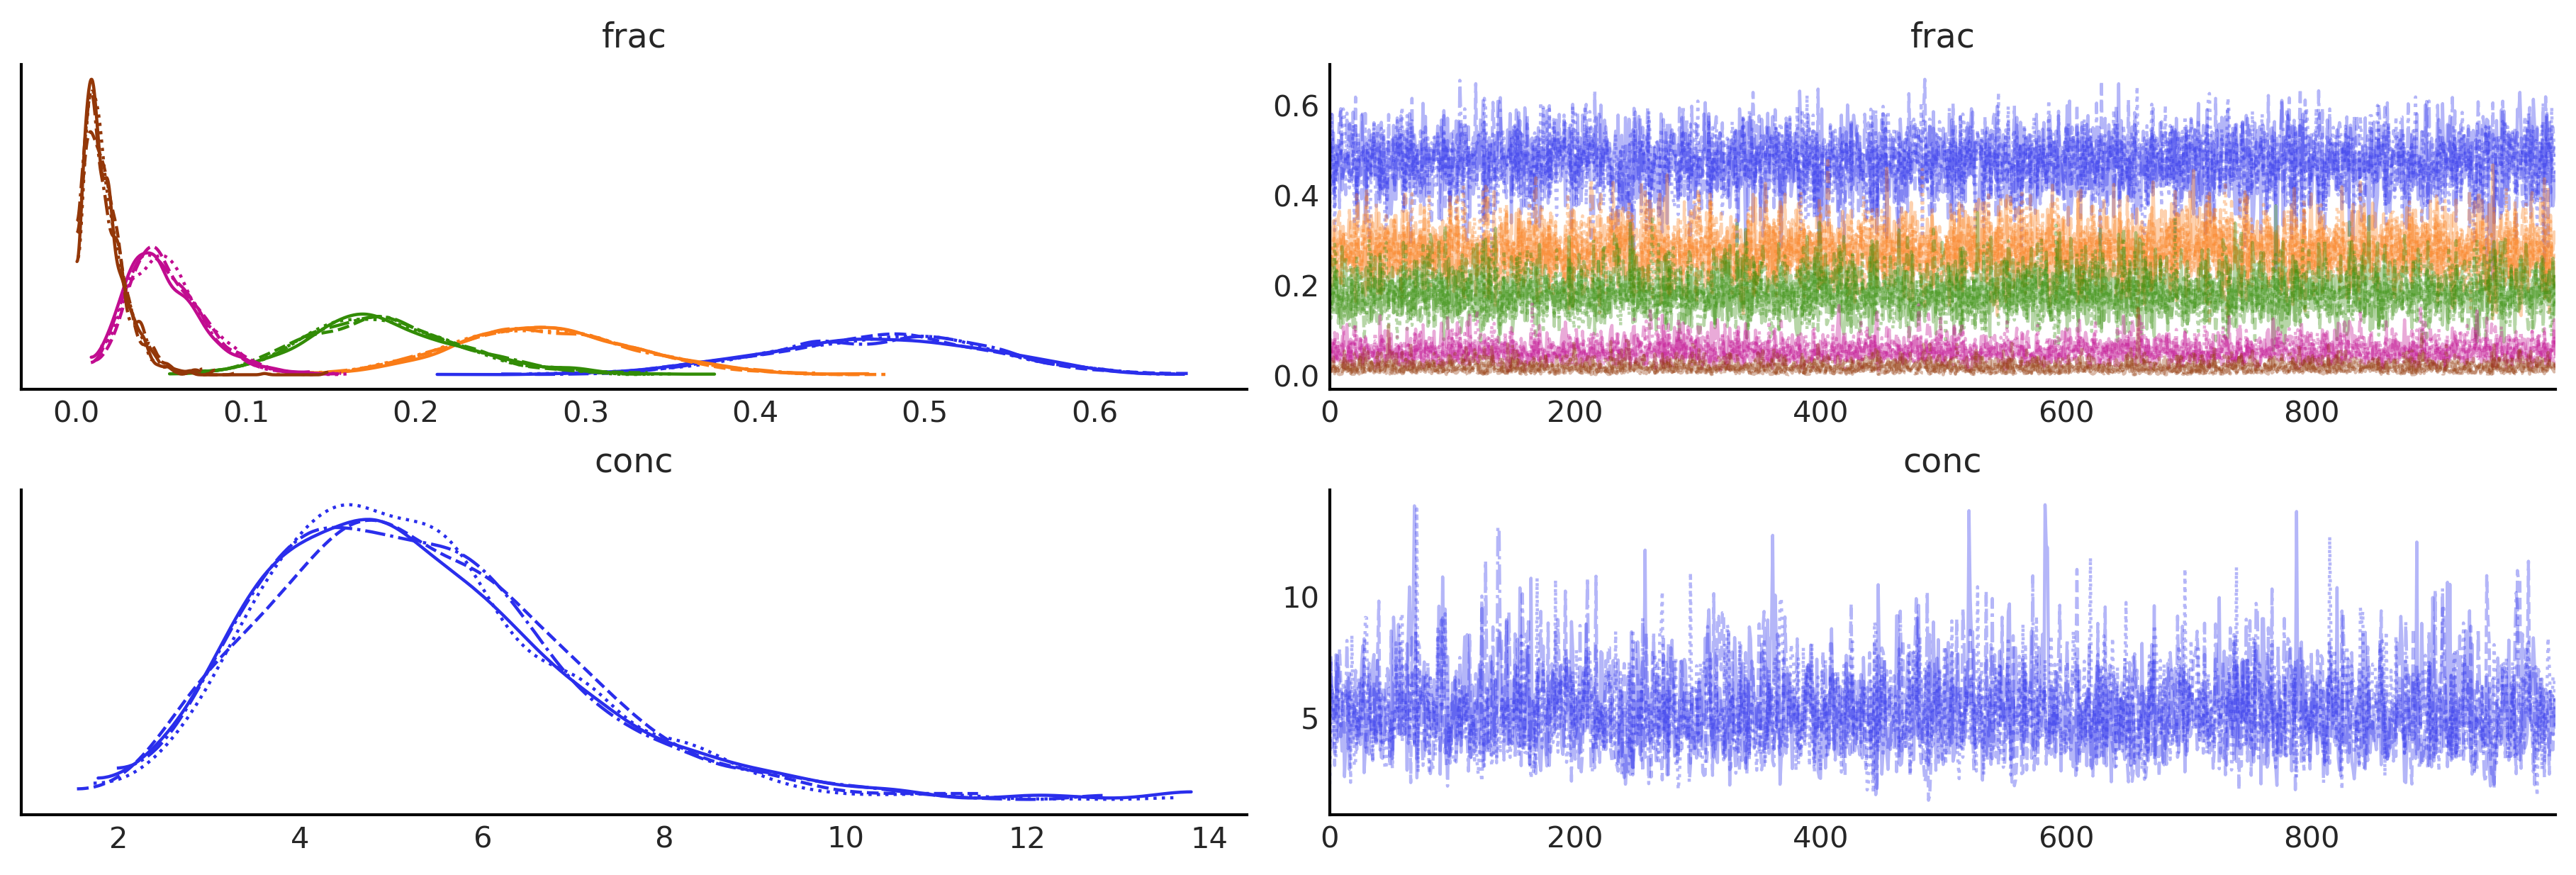

In [35]:
az.plot_trace(data=idata_dmm, var_names=["frac", "conc"]);

In [36]:
summary_dmm = az.summary(idata_dmm, var_names=["frac", "conc"])
summary_dmm = summary_dmm.assign(
    ess_mean_per_sec=lambda x: x.ess_bulk / idata_dmm.posterior.sampling_time,
)
assert all(summary_dmm.r_hat < 1.03)

summary_dmm

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk   
frac[pine]      0.472  0.065   0.347    0.587      0.001    0.001    4029.0  \
frac[oak]       0.276  0.053   0.176    0.374      0.001    0.001    4738.0   
frac[ebony]     0.182  0.046   0.095    0.267      0.001    0.001    4269.0   
frac[rosewood]  0.053  0.022   0.016    0.095      0.000    0.000    2456.0   
frac[mahogany]  0.017  0.012   0.001    0.039      0.000    0.000    2890.0   
conc            5.282  1.678   2.515    8.427      0.032    0.023    2712.0   

                ess_tail  r_hat  ess_mean_per_sec  
frac[pine]        2774.0    1.0       1388.490913  
frac[oak]         2990.0    1.0       1632.829473  
frac[ebony]       3030.0    1.0       1471.200722  
frac[rosewood]    2342.0    1.0        846.397042  
frac[mahogany]    2513.0    1.0        995.963946  
conc              2802.0    1.0        934.620838

/tmp/ipykernel_63967/1701302770.py:30: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in axes[-2].get_legend().legendHandles:


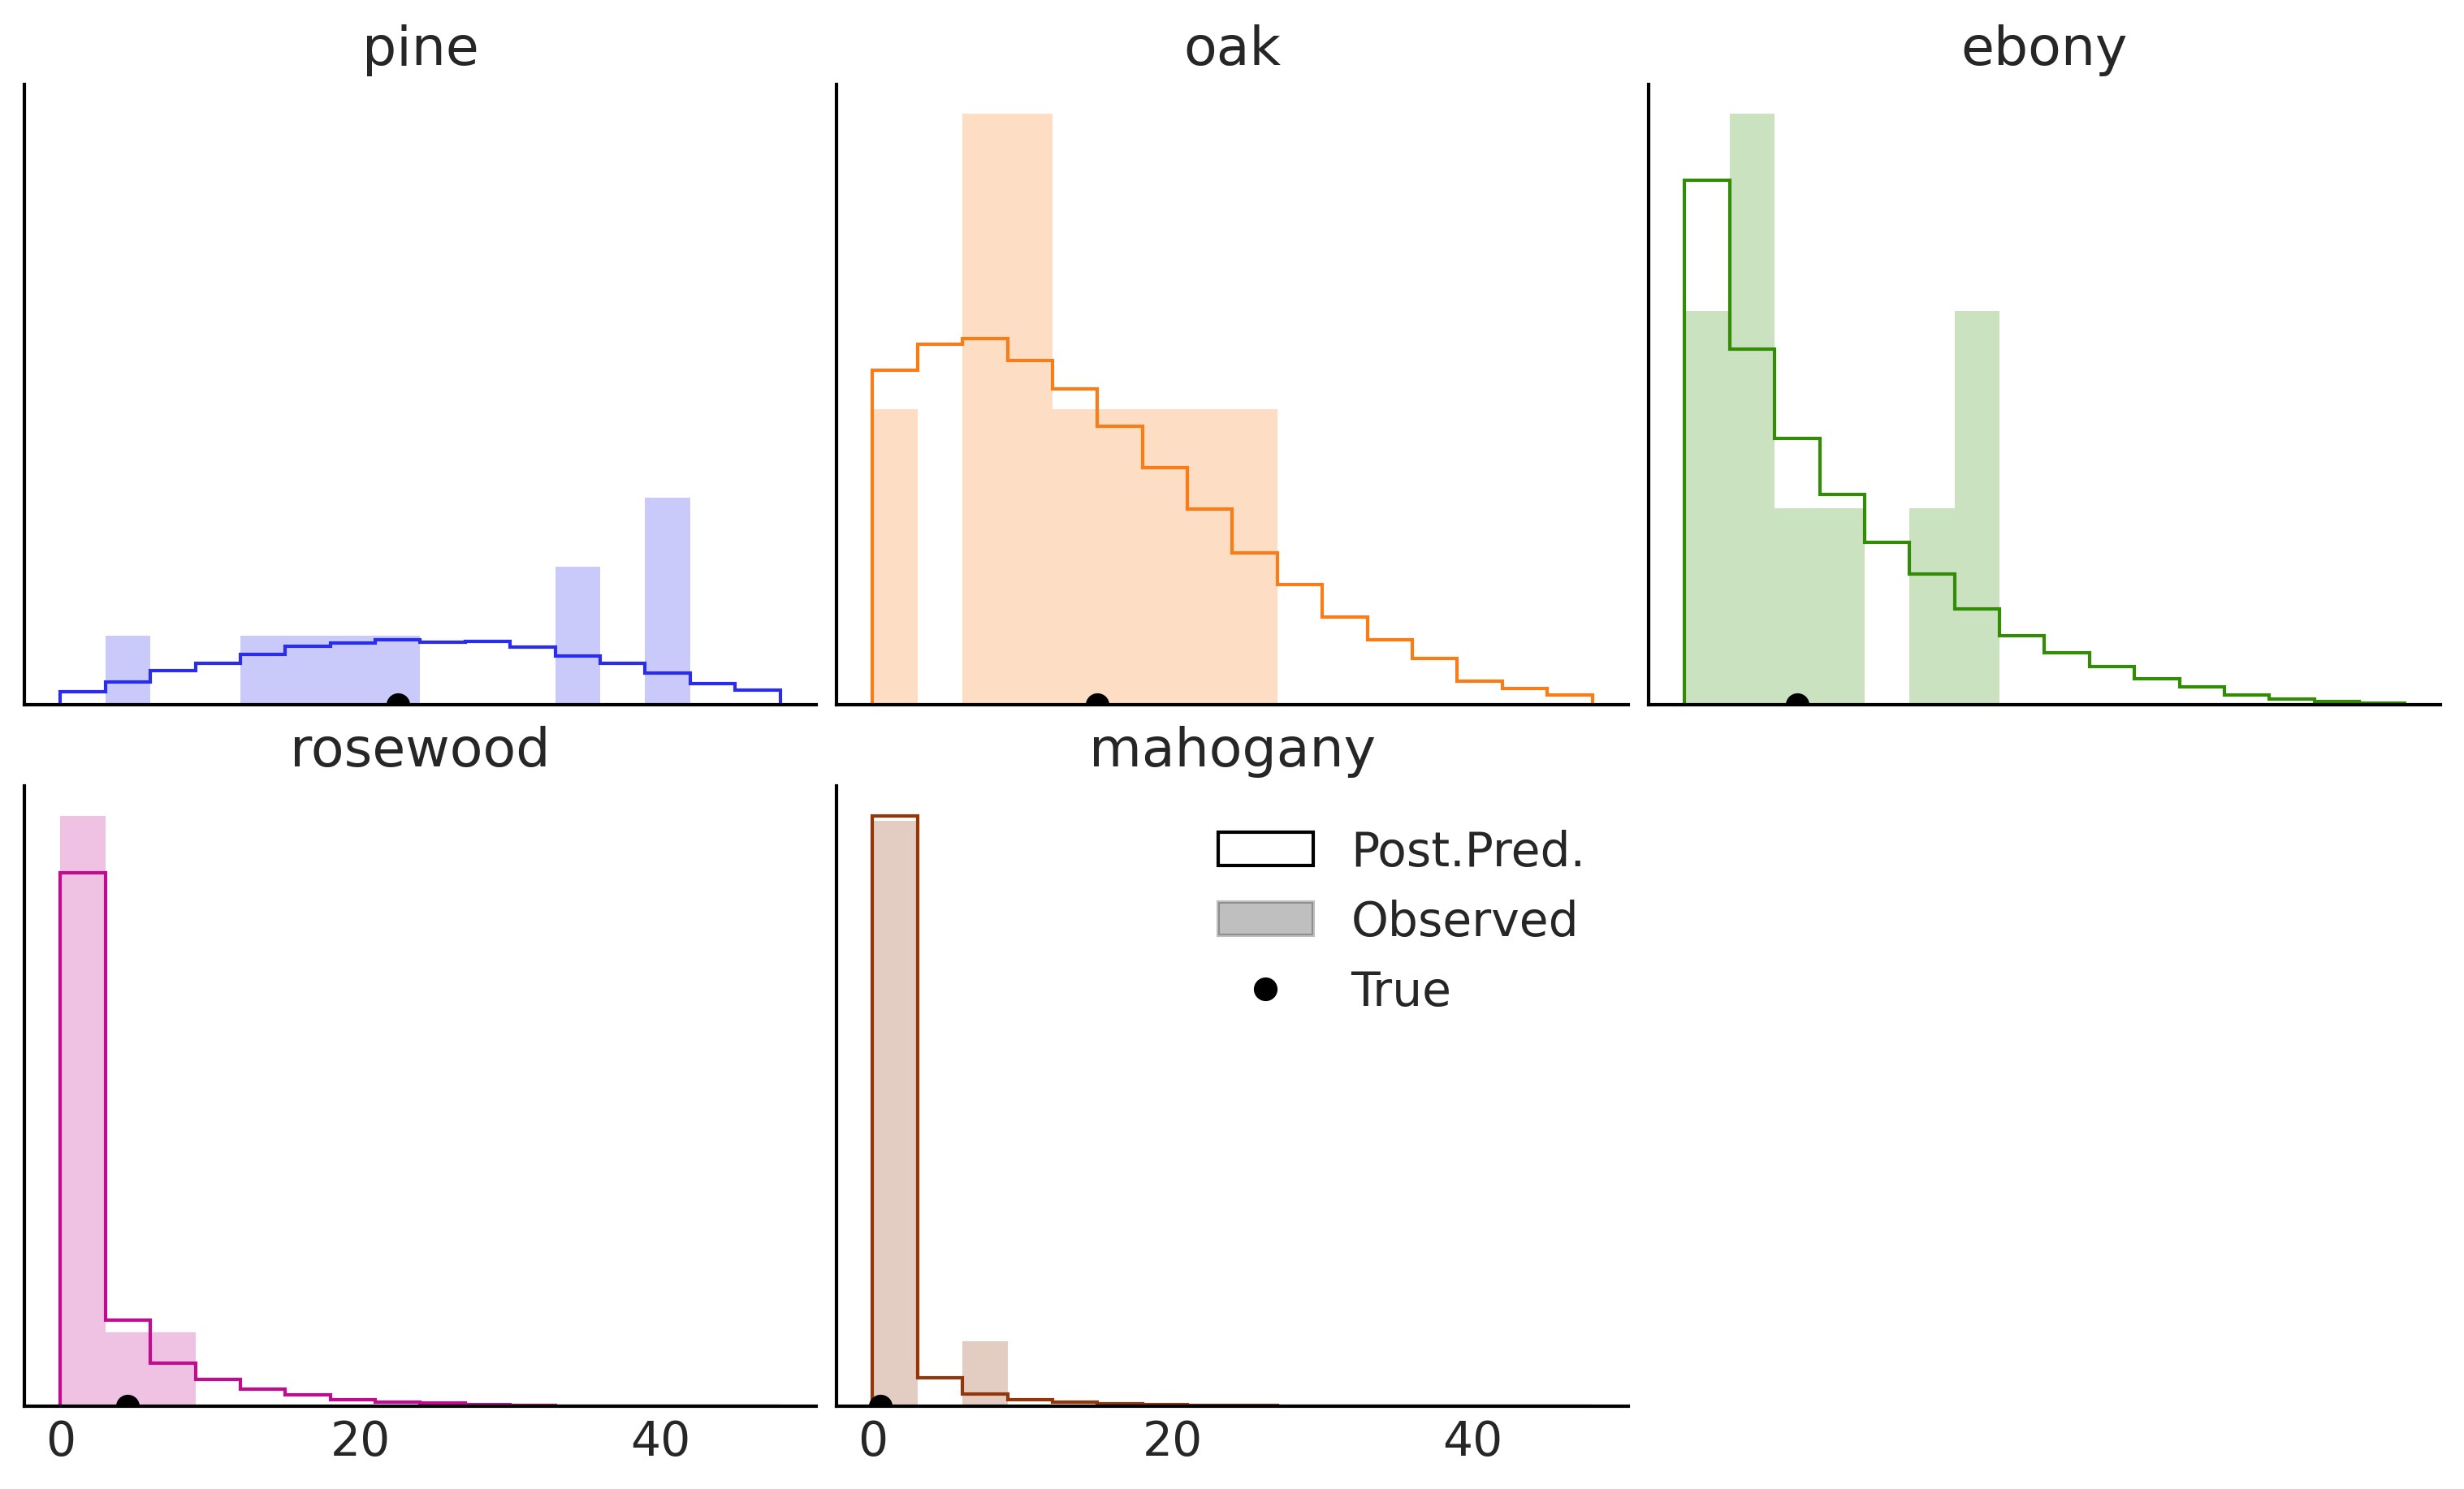

In [37]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:5]
bins = np.arange(total_count, step=3)
fig, axes = plt.subplots(2, 3, sharex=True, figsize=(10, 6))
axes = axes.ravel()
axes[-1].remove()
for i, (c, ax) in enumerate(zip(colors, axes)):
    ax.hist(
        idata_dmm.posterior_predictive.counts.sel(tree=trees[i]).values.flatten(),
        bins=bins,
        histtype="step",
        color=c,
        density=True,
        label="Post.Pred.",
    )
    ax.hist(
        idata_dmm.observed_data.counts.sel(tree=trees[i]).values,
        bins=bins,
        color=c,
        density=True,
        alpha=0.25,
        label="Observed",
    )
    ax.plot(true_frac[i] * total_count, 0, "ko", label="True")
    ax.set_title(f"{trees[i]}")
    ax.set_yticks([])

axes[-2].legend(loc="upper right")
axes[-1].set_xlabel("Count")
axes[0].set_ylim(0, 0.3)
for lh in axes[-2].get_legend().legendHandles:
    lh.set_color('black')
plt.savefig("dirichlet_posterior_predictive_check.png")

In [38]:
idata_dmm.posterior.sel(tree="pine")

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
    tree     <U8 'pine'
Data variables:
    frac     (chain, draw) float64 0.4634 0.439 0.5793 ... 0.5503 0.502 0.5087
    conc     (chain, draw) float64 6.125 6.313 6.17 5.421 ... 3.632 5.616 5.91
Attributes:
    created_at:                 2023-05-29T17:41:46.429757
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.3.1
    sampling_time:              2.9017114639282227
    tuning_steps:               1000

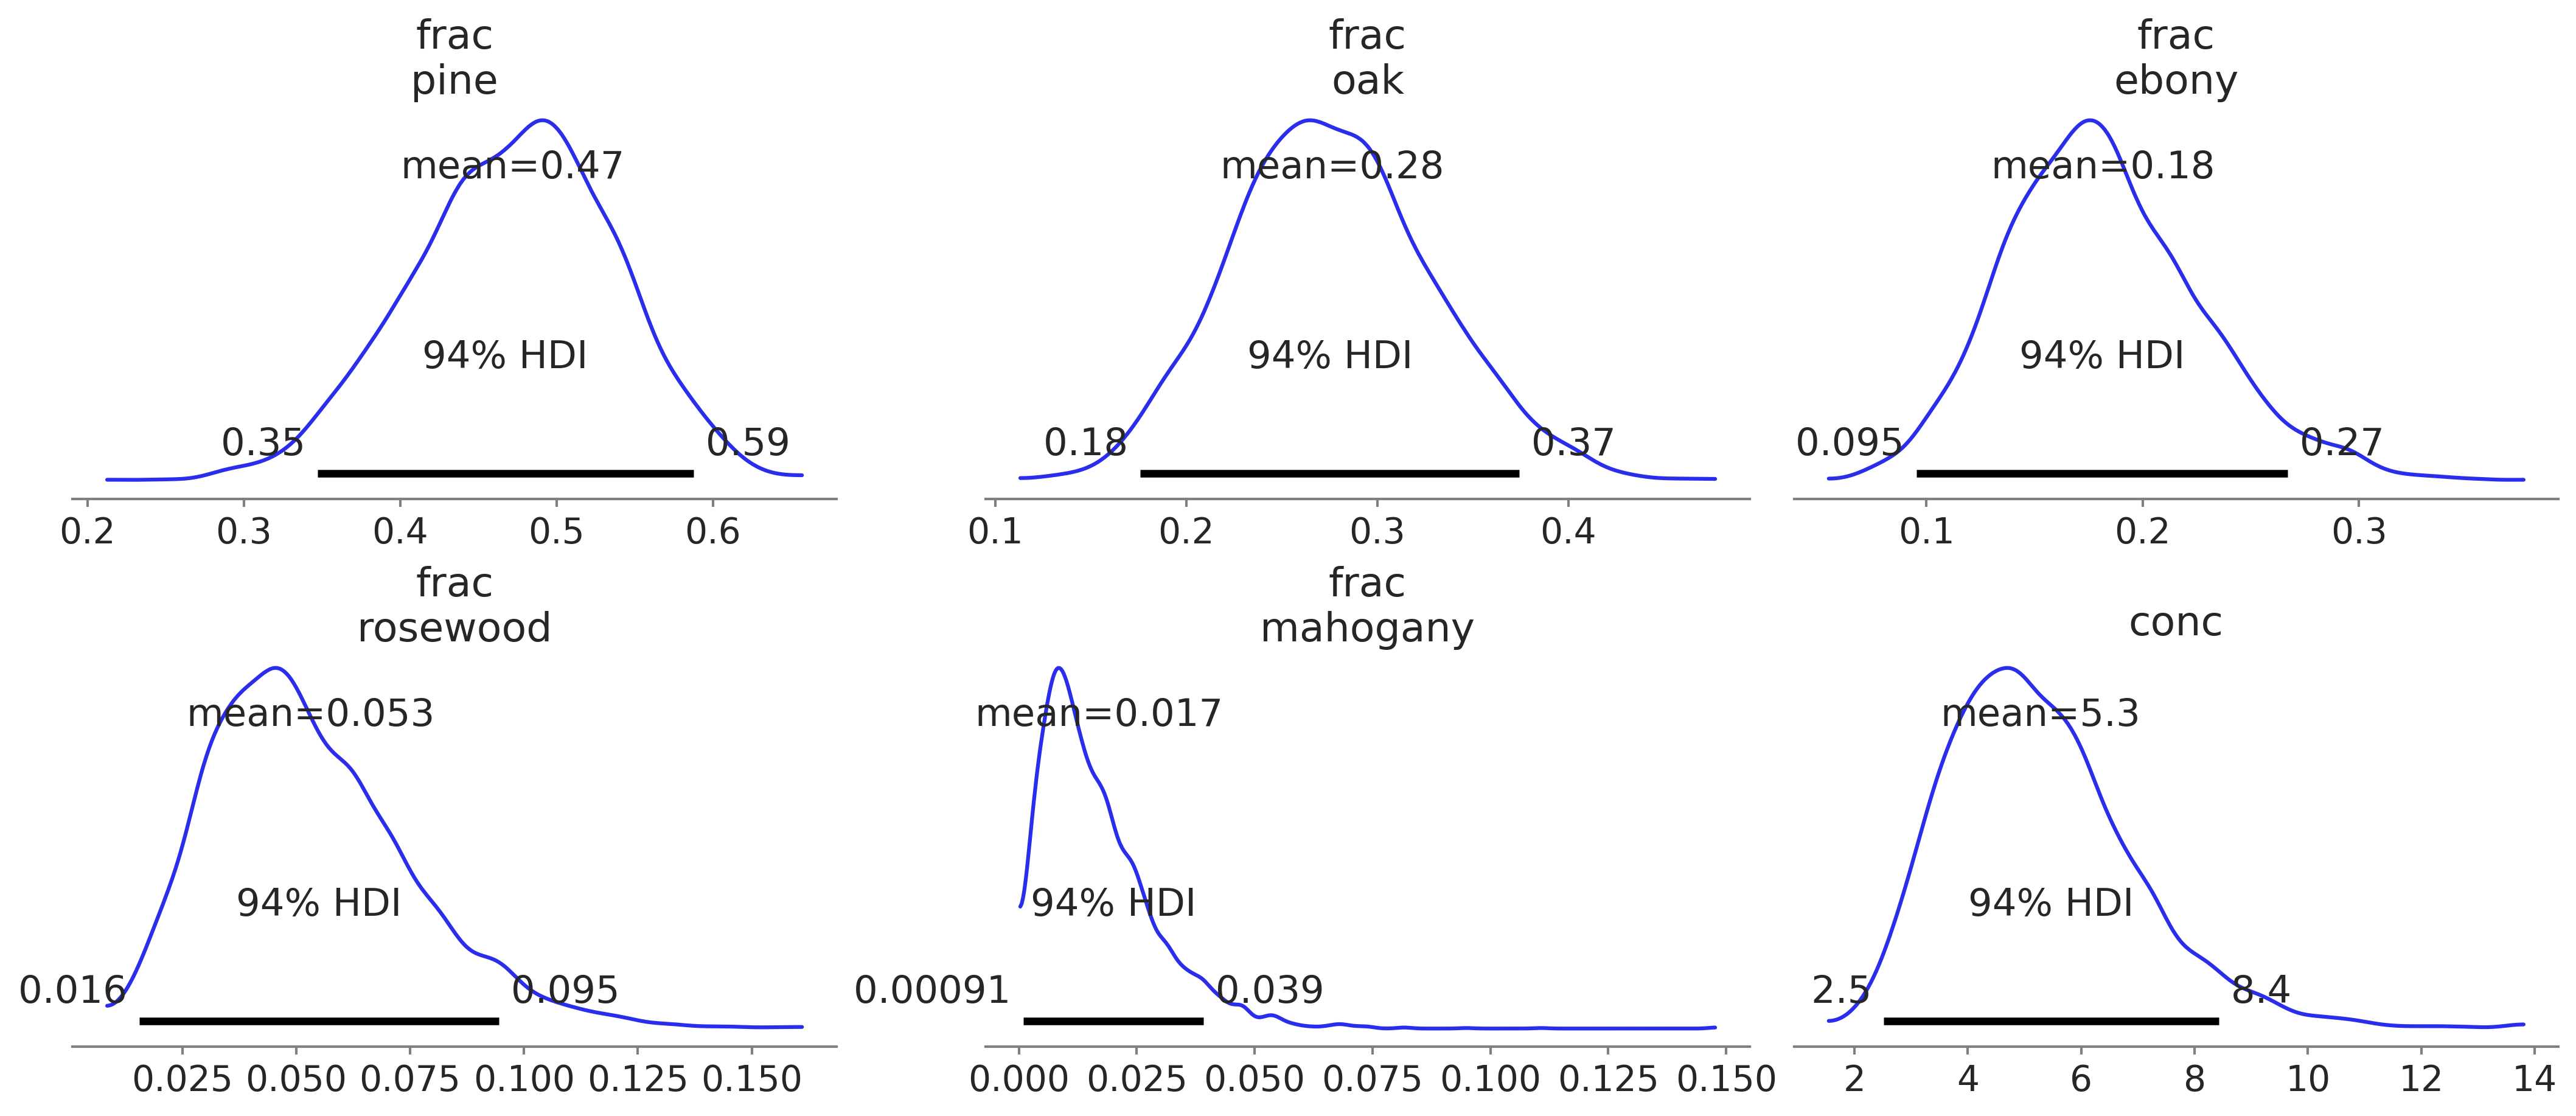

In [39]:
az.plot_posterior(idata_dmm, figsize=(14, 6))
plt.savefig("dirichlet_posterior.png")

### JAX-based sampling

```python
with pm.Model() as tennis_model:
    sd = pm.HalfNormal("sd", sigma=1.0)
    skill_raw = pm.Normal("skill_raw", 0.0, sigma=1.0,
                          shape=(n_players,)
    )
    skill = pm.Deterministic("skill", skill_raw * sd)

    logit_skill = skill[winner_ids] - skill[loser_ids]
    win = pm.Bernoulli("win", logit_p=logit_skill,
                       observed=np.ones(winner_ids.shape[0])
    )
```

## Pytensor

In [40]:
import pytensor
import pytensor.tensor as pt

In [41]:
x = pt.scalar(name="x")
y = pt.vector(name="y")
z = pt.log(x + y)
z.name = "log(x + y)"

In [42]:
f = pytensor.function(inputs=[x, y], outputs=z)
f(x=0, y=[1, np.e])

array([0., 1.])

In [43]:
x = pm.Normal.dist(mu=0, sigma=1)
x_draws = pm.draw(x, draws=1_000, random_seed=7)
x_logp = pm.logp(rv=x, value=[x_draws]).eval()

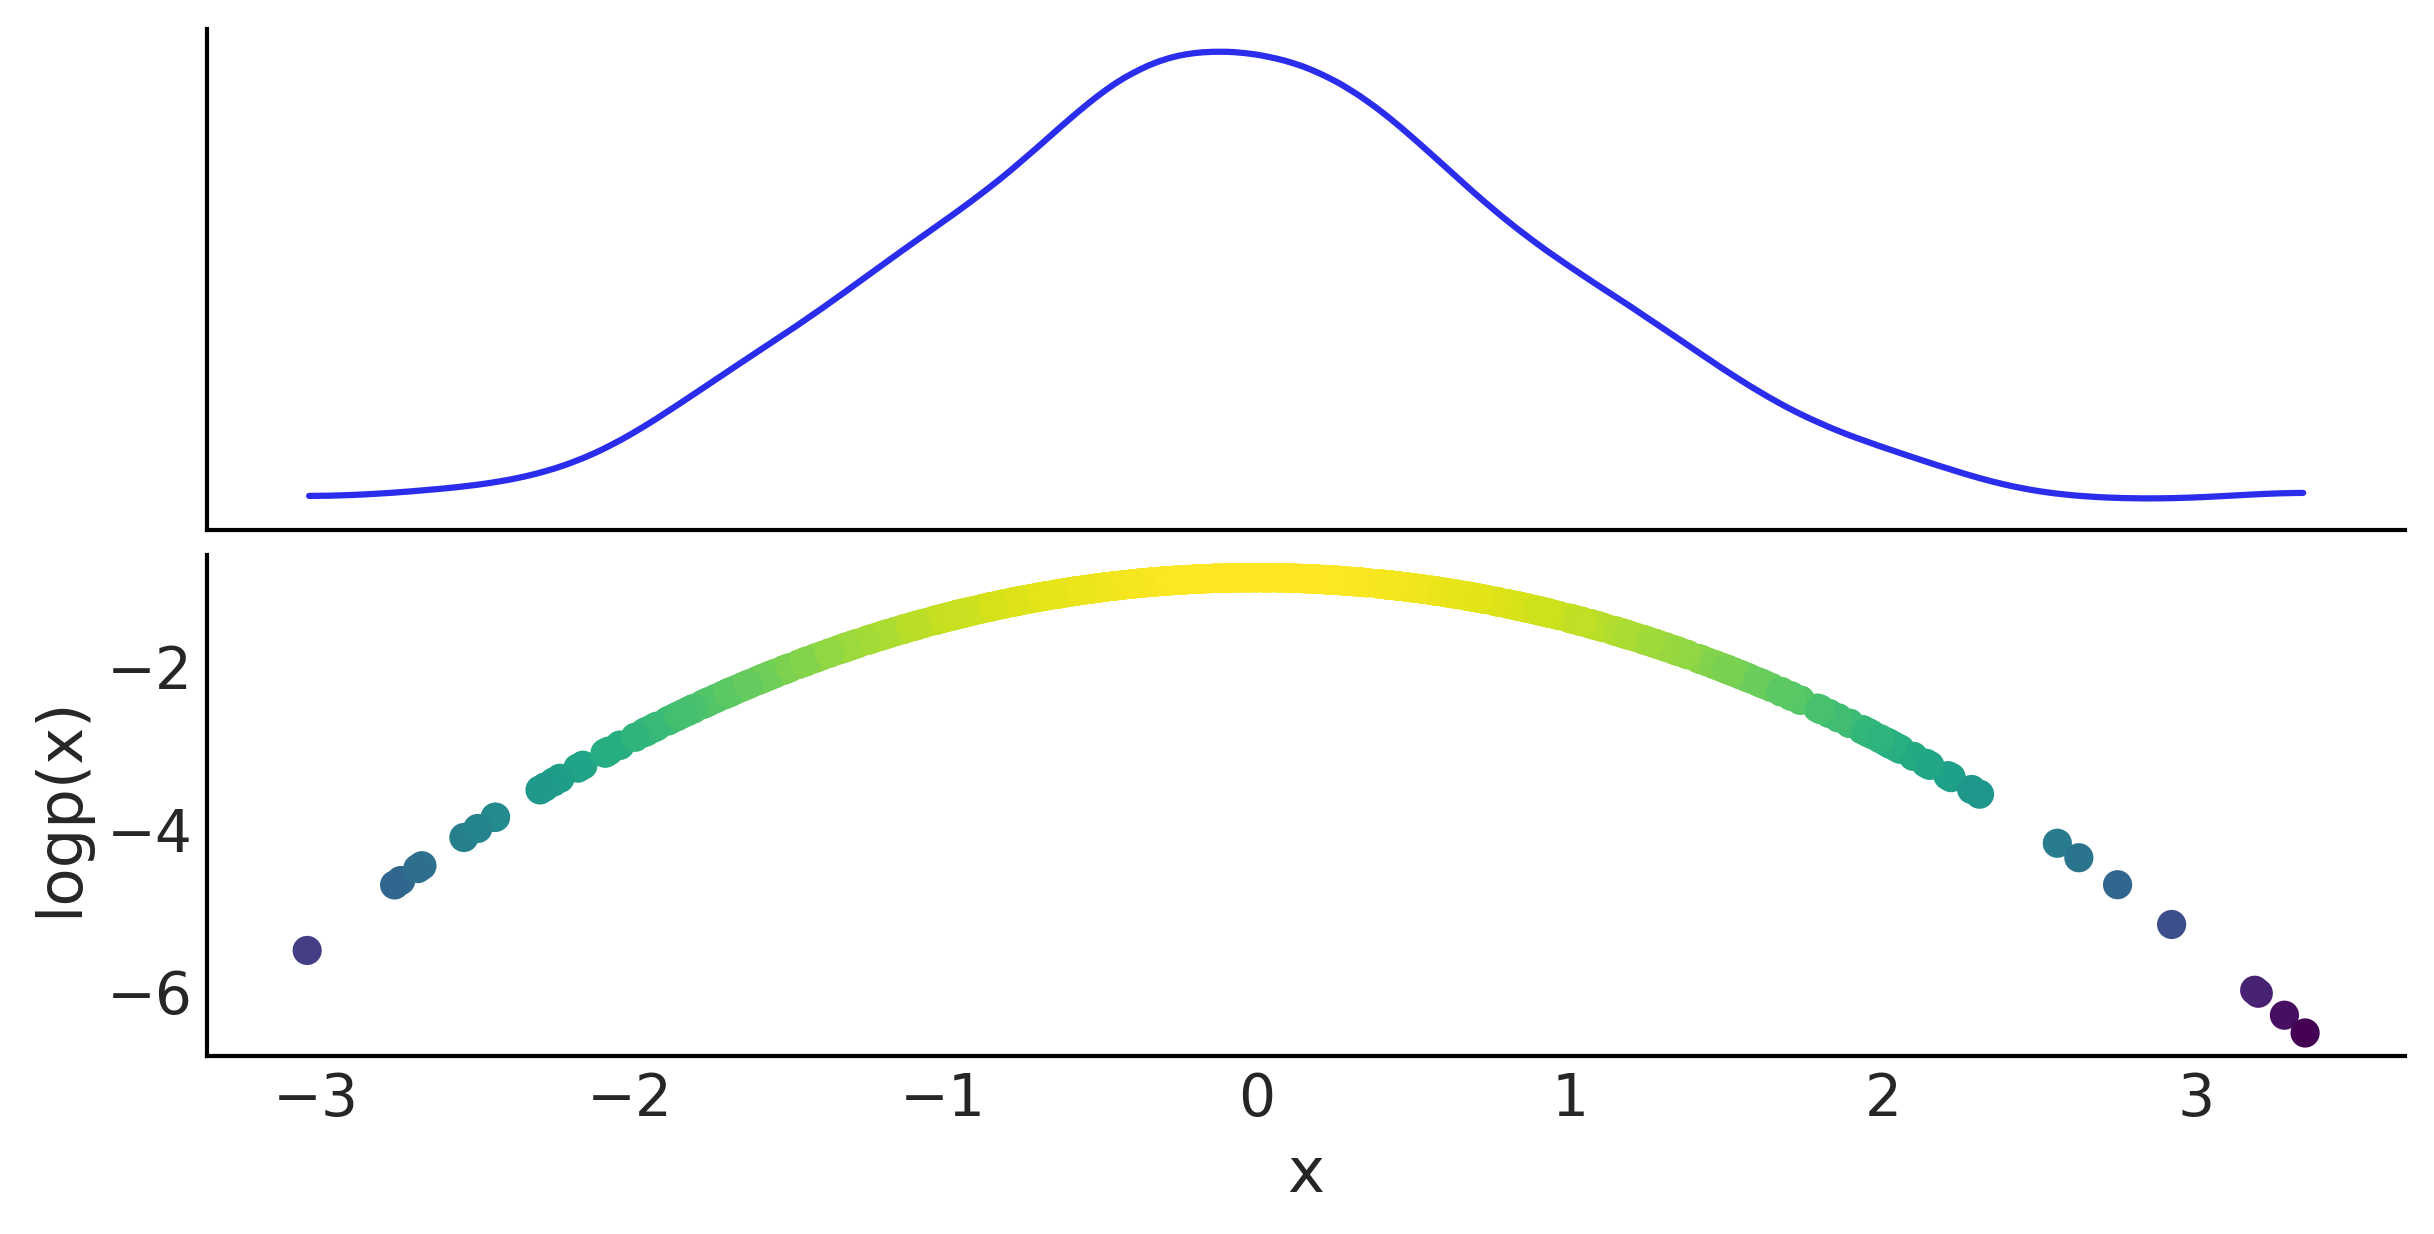

In [44]:
_, axes = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
az.plot_kde(x_draws, ax=axes[0])
axes[0].set_yticks([])
axes[1].scatter(x_draws, x_logp, c=x_logp)
axes[1].set_xlabel("x")
axes[1].set_ylabel("logp(x)")
plt.savefig("pytensor_rvs.png")

In [45]:
%load_ext watermark

In [46]:
%watermark -iv

pandas    : 1.5.3
scipy     : 1.10.1
pymc      : 5.0.2
matplotlib: 3.7.1
pytensor  : 2.11.3
numpy     : 1.23.5
arviz     : 0.16.0.dev0

